In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle
import seaborn as sns
import keras
#from keras.applications.densenet import DenseNet121,DenseNet201, DenseNet169
from keras.layers import Input
from keras.models import Model, Sequential, model_from_json, load_model
from keras.layers import Dense, InputLayer, AveragePooling2D, Flatten, Dropout, Conv2D
from keras.optimizers import Adam
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#from generator import DataGenerator

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
weights_dir = '/content/drive/My Drive/Capstone/PretrainedWeights/'

chexnet_weights_file = os.path.join(weights_dir, 'brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

In [19]:
!ls '/content/drive/My Drive/Capstone/PretrainedWeights/'

brucechou1983_CheXNet_Keras_0.3.0_weights.h5  trained_model.json


In [0]:
#Create structure from trained and saved json file
json_file=  open(weights_dir +'trained_model.json', 'r') #'model_train.h5')
trained_model_json = json_file.read()
json_file.close()


chexnet_model = model_from_json(trained_model_json)

#Load weights to newly created model from json
chexnet_model.load_weights(chexnet_weights_file)

In [8]:
chexnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [21]:
#chexnet_model.layers.pop()
#chexnet_model.layers.pop()
chexnet_model.layers.pop()
chexnet_model.layers.pop()
chexnet_model.layers.pop()

In [0]:
for layer in chexnet_model.layers:
    layer.trainable=False

temp_model = Sequential()
temp_model.add(Dense(1024, activation='relu'))
temp_model.add(Dropout(0.25))
temp_model.add(Dense(512, activation='relu'))
temp_model.add(Dropout(0.25))
temp_model.add(Dense(256, activation='relu'))
temp_model.add(Dropout(0.25))
temp_model.add(Dense(1, activation='sigmoid'))


model = Model(inputs=chexnet_model.input, outputs=temp_model(chexnet_model.output))

In [0]:
'''for layer in chexnet_model.layers[:-1]:
    layer.trainable=False

temp_model = chexnet_model.layers[-2].output
#temp_model=Flatten()(temp_model)
temp_model = Dense(512, activation='relu')(temp_model)
temp_model=Dropout(0.25)(temp_model)
temp_model= Dense(256, activation='relu')(temp_model)
predictions =Dense(1, activation='sigmoid')(temp_model)


model = Model(inputs=chexnet_model.input, outputs= predictions)'''

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [35]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/Capstone/train_png/',
        target_size=(224, 224),
        batch_size=128,color_mode='rgb',
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/My Drive/Capstone/validation_png/',
        target_size=(224, 224),
        batch_size=128,color_mode='rgb',
        class_mode='binary')

'''test_generator = test_datagen.flow_from_directory(
        '/content/drive/My Drive/Capstone/test_png/',
        target_size=(224, 224),
        batch_size=16,color_mode='rgb',
        class_mode='binary')'''

Found 4838 images belonging to 2 classes.
Found 441 images belonging to 2 classes.


"test_generator = test_datagen.flow_from_directory(\n        '/content/drive/My Drive/Capstone/test_png/',\n        target_size=(224, 224),\n        batch_size=16,color_mode='rgb',\n        class_mode='binary')"

In [0]:
#log loss or cross entropy 
adam = Adam(lr=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


In [37]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=0, mode='auto')
reducelr =  ReduceLROnPlateau(monitor = "val_loss", factor = 0.001, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-08, cooldown = 0, min_lr = 0.0001)
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/Capstone/chexnet_weights_pnemonia_adam2.h5' , monitor='val_loss',verbose=1,save_best_only=True, save_weights_only=True,mode='val_acc' ,)
batch_size=64
model.fit_generator(
        train_generator,
        steps_per_epoch=4800// batch_size,
        epochs=100,
        validation_data=validation_generator,callbacks=[checkpointer],
        validation_steps=440 // batch_size)

model.save("/content/drive/My Drive/Capstone/model_pnemonia_adam2.h5")


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:407: RuntimeWarning: ModelCheckpoint mode val_acc is unknown, fallback to auto mode.
  RuntimeWarning)


Epoch 1/100
75/75 [==============================] - 170s 2s/step - loss: 0.5440 - acc: 0.7252 - val_loss: 0.5473 - val_acc: 0.7145

Epoch 00001: val_loss improved from inf to 0.54732, saving model to /content/drive/My Drive/Capstone/chexnet_weights_pnemonia_adam2.h5
Epoch 2/100
75/75 [==============================] - 154s 2s/step - loss: 0.4281 - acc: 0.8056 - val_loss: 0.6105 - val_acc: 0.6757

Epoch 00002: val_loss did not improve from 0.54732
Epoch 3/100
75/75 [==============================] - 157s 2s/step - loss: 0.4180 - acc: 0.8070 - val_loss: 0.5697 - val_acc: 0.7044

Epoch 00003: val_loss did not improve from 0.54732
Epoch 4/100
75/75 [==============================] - 156s 2s/step - loss: 0.4136 - acc: 0.8081 - val_loss: 0.6338 - val_acc: 0.6629

Epoch 00004: val_loss did not improve from 0.54732
Epoch 5/100
75/75 [==============================] - 158s 2s/step - loss: 0.4206 - acc: 0.8032 - val_loss: 0.5241 - val_acc: 0.7245

Epoch 00005: val_loss improved from 0.54732 to 

In [0]:
#for layer in model.layers:
 #   layer.trainable = True

In [20]:

# Check the trainable status of the individual layers
for layer in model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f284c323518> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f284c323588> False
<keras.layers.convolutional.Conv2D object at 0x7f284c323748> False
<keras.layers.normalization.BatchNormalization object at 0x7f284c3237b8> False
<keras.layers.core.Activation object at 0x7f284c3239e8> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f284c323be0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f284c323c18> False
<keras.layers.normalization.BatchNormalization object at 0x7f284c323c50> False
<keras.layers.core.Activation object at 0x7f284c323cf8> False
<keras.layers.convolutional.Conv2D object at 0x7f284c323e10> False
<keras.layers.normalization.BatchNormalization object at 0x7f284c323e48> False
<keras.layers.core.Activation object at 0x7f284babc128> False
<keras.layers.convolutional.Conv2D object at 0x7f284babc160> False
<keras.layers.merge.Concatenate object at 0x7f284babc2e8> False
<keras.layers.normalization.

In [0]:
Dir

[]

In [38]:
import os
import cv2 

data = []
labels = []

patientID=[]
filename=[]
TestDir= '/content/drive/My Drive/Capstone/validation_png/'

# loop over the input images
dirs = os.listdir(TestDir) 
for dir in dirs:
    absDirPath = os.path.join(os.path.sep,TestDir, dir)
    images = os.listdir(absDirPath)
    for imageFileName in images:
        
        # load the image, pre-process it, and store it in the data list
        imageFullPath = os.path.join(TestDir, dir, imageFileName)
        #print(imageFullPath)
        img = load_img(imageFullPath)
        arr = img_to_array(img)  #Numpy array with shape (233,233,3)
        arr = cv2.resize(arr, (224,224)) #Numpy array with shape (HEIGHT, WIDTH,3)
        #print(arr.shape)
        data.append(arr)
        patientID.append(imageFileName.split('/')[-1].split('.')[0])
        #print(patientID)
        filename.append(imageFullPath)
        
        #label = classes_to_int(dir)
        if(dir== 'validation_pneumonia'):
          label=1
        else:
          label=0
        #print(label)
        labels.append(label)
    print(len(images))
    
print('Number of images :-',len(data))
print('Number of Labels',len(labels))
print('Number of patientID :-',len(patientID))
print(len(filename))

191
250
Number of images :- 441
Number of Labels 441
Number of patientID :- 441
441


In [0]:
Valid_df = pd.DataFrame({ 
                        'patientId':patientID,
                       'images':data,
                        'Labels': labels,
                         'Filenames':filename
                         })





In [0]:
model= load_model("/content/drive/My Drive/Capstone/model_pnemonia_adam2.h5")
y_preds=[]
for img in Valid_df['images']:
  img=img.reshape(-1,224,224,3)
  pred_1=model.predict(img)
  y_preds.append(pred_1)
  

In [0]:
Valid_df['preds']=y_preds

In [42]:
Valid_df['Labels'].value_counts()

0    250
1    191
Name: Labels, dtype: int64

In [43]:
Valid_df[['Labels', 'preds']]

,Labels,preds
0,1,[[0.028730966]]
1,1,[[0.028730966]]
2,1,[[0.028730966]]
3,1,[[0.028730966]]
4,1,[[0.028730966]]
5,1,[[0.028730966]]
6,1,[[0.028730966]]
7,1,[[0.028730966]]
8,1,[[0.028730966]]
9,1,[[0.028730966]]


In [0]:
y_preds_1=y_preds

In [0]:
preds=[]
for i, predicted in enumerate(y_preds_1):
  if (predicted[0][0])>=0.4:
    value=1
    preds.append(value)
      
    
  else :
    value=0
    preds.append(value)

In [0]:
y_val=Valid_df['Labels']

In [31]:
from sklearn.metrics import confusion_matrix,classification_report
print("\nConfusion_Marix is :\n",confusion_matrix(y_val, preds))
print("\nClassification_Report is :\n",classification_report(y_val,preds))


Confusion_Marix is :
 [[250   0]
 [191   0]]

Classification_Report is :
               precision    recall  f1-score   support

           0       0.57      1.00      0.72       250
           1       0.00      0.00      0.00       191

    accuracy                           0.57       441
   macro avg       0.28      0.50      0.36       441
weighted avg       0.32      0.57      0.41       441



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


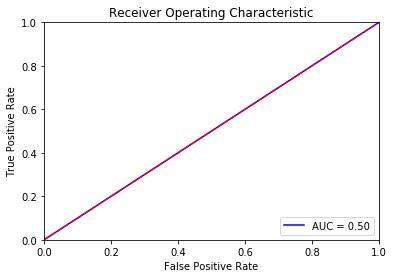

In [32]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
